# 🚀 Inference Optimization: Server-Side and Client-Side Caching

In previous notebooks, we explored **model compression** techniques (like quantization and pruning) and **Parameter-Efficient Fine-Tuning (PEFT)** methods such as **LoRA**.
These approaches helped us **reduce training cost and memory footprint** while keeping model performance strong.

Now, we shift our focus from **training efficiency** to **inference efficiency** — optimizing how the model serves predictions once deployed.

### 🧠 Why Optimize Inference?

Even after training, large language models remain computationally heavy:
- Each token generation step can require billions of FLOPs.
- Repeated computations across requests waste valuable GPU cycles.
- Memory bandwidth and latency can quickly become bottlenecks.

Inference optimizations allow us to:
- ⚡ Reduce response latency (faster generations)
- 💸 Lower compute cost per request
- 🧩 Serve more users concurrently with the same hardware


### 🧩 What We’ll Cover

We’ll study **two complementary caching strategies** — one on the **server side** and one on the **client side**, that make inference significantly faster and more efficient.

#### 🔹 1. Server-Side Optimization — *KV Caching (via vLLM)*  
> Used during token generation to reuse attention key/value pairs, avoiding redundant computation.

We’ll see how **vLLM** implements KV caching with its **PagedAttention** mechanism, achieving high throughput and efficient GPU memory usage for large-scale serving.

#### 🔹 2. Client-Side Optimization — *CacheSaver*  
> Used to locally store and reuse model responses or intermediate computations on the client side.

We’ll explore how **CacheSaver** helps avoid repeated inference calls for identical inputs, reducing latency and API costs.


### 🎯 Learning Goals
By the end of this notebook, you’ll:
- Understand how **KV caching** speeds up sequential generation.
- Learn how **vLLM** leverages **PagedAttention** for scalable inference.
- Implement a **CacheSaver** for efficient client-side reuse.
- Measure real-world performance gains from both techniques.


Let’s dive in and make inference *blazingly fast*! ⚡


In [1]:
import time
from transformers import AutoModelForCausalLM, AutoTokenizer
from vllm import LLM, SamplingParams
import matplotlib.pyplot as plt
import numpy as np

INFO 11-12 03:49:45 [__init__.py:216] Automatically detected platform cuda.


## 🧪 Comparing Inference Performance: Transformers vs vLLM

In this experiment, we’ll benchmark the inference speed of **Transformers** and **vLLM** using the `facebook/opt-125m` model.  
The model will be asked to **explain in detail how the internet works**, from connecting to Wi-Fi to rendering a website in a browser.  

We’ll:
- Run **10 generations** for each framework  
- Measure and record inference times  
- Visualize per-run and average performance  

Set `verbose = True` if you’d like to print model outputs during testing.


In [ ]:
model_name = "facebook/opt-125m"
prompt = "Explain in detail how the internet works, starting from how a computer connects to a Wi-Fi network all the way to how a website appears in a browser. Include examples and describe each step carefully."
verbose = False # Switch to True if you want the model's outputs printed

### Transformers

Let's first execute the experiment using Transformers

**`TODO:`**
1. Initialize the model using Transformers for Causal Language Modeling.
2. Use the model to generate 10 output samples. All generations should have the following decoding parameters:
    - `max_new_tokens`=1024
    - `do_sample`=True
    - `temperature`=0.7
    - `top_p`=0.9
3. Measure the time needed for each generation and then compute their average.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

transformers_times = []
for i in range(10):
    start = time.time()
    inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to("cuda")

    output = model.generate(
        **inputs,
        max_new_tokens=1024,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
    )

    torch_time = time.time() - start
    transformers_times.append(torch_time)

    text_out = tokenizer.decode(output[0], skip_special_tokens=True)
    if verbose:
        print(f"\nRun {i+1} output:\n{text_out}\n")
    print(f"⏱ Transformers time (run {i+1}): {torch_time:.2f} s")

print(f"\nAverage Transformers time over 10 runs: {sum(transformers_times)/len(transformers_times):.2f} s")


⏱ Transformers time (run 1): 14.42 s
⏱ Transformers time (run 2): 9.19 s
⏱ Transformers time (run 3): 8.74 s
⏱ Transformers time (run 4): 9.37 s
⏱ Transformers time (run 5): 9.20 s
⏱ Transformers time (run 6): 9.23 s
⏱ Transformers time (run 7): 16.69 s
⏱ Transformers time (run 8): 26.02 s
⏱ Transformers time (run 9): 9.14 s
⏱ Transformers time (run 10): 8.99 s

Average Transformers time over 10 runs: 12.10 s


### vLLM
- **vLLM** is an open-source **high-performance inference and serving engine** for large language models (LLMs).  
- It’s designed to make model serving **much faster and more memory-efficient** through **KV caching** and an advanced mechanism called **PagedAttention**.  
- Traditional inference engines store key–value (KV) caches contiguously in GPU memory, which limits concurrency. vLLM’s **PagedAttention** treats attention cache memory like a **virtual memory system**, breaking it into small “pages” that can be dynamically allocated, reused, and evicted.  
- This enables **many concurrent requests**, **lower latency**, and **higher GPU utilization** — ideal for production-scale LLM serving.  
- vLLM can be used both **locally and in the cloud**, providing fast and cost-efficient inference for chatbots, code assistants, and other AI applications.

Check out vLLM’s GitHub: [https://github.com/vllm-project/vllm](https://github.com/vllm-project/vllm) 🚀


Now let's repeat the experiment using vLLM. Initializing a model and making generations using vLLM is similar to Transformers but not exactly the same. The example below, shows everything you need for this exercise.

```python
llm = LLM(model=model_name)
sampling_params = SamplingParams(max_tokens=1024, temperature=0.7, top_p=0.9)
outputs = llm.generate([prompt], sampling_params)
```

**`TODO:`**
1. Initialize the model using vLLM.
2. Use the model to generate 10 output samples. All generations should have the following decoding parameters:
    - `max_new_tokens`=1024
    - `do_sample`=True
    - `temperature`=0.7
    - `top_p`=0.9
3. Measure the time needed for each generation and then compute their average.

In [ ]:
llm = LLM(model=model_name)
sampling_params = SamplingParams(max_tokens=1024, temperature=0.7, top_p=0.9)

vllm_times = []
for i in range(10):
    start = time.time()
    outputs = llm.generate([prompt], sampling_params)
    vllm_time = time.time() - start
    vllm_times.append(vllm_time)

    if verbose:
        print(f"\nRun {i+1} vLLM output:\n{outputs[0].outputs[0].text.strip()}\n")
    print(f"⚡ vLLM time (run {i+1}): {vllm_time:.2f} s")

print(f"\nAverage vLLM time over 10 runs: {sum(vllm_times)/len(vllm_times):.2f} s")

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚡ vLLM time (run 1): 9.87 s


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚡ vLLM time (run 2): 8.91 s


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚡ vLLM time (run 3): 2.20 s


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚡ vLLM time (run 4): 7.07 s


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚡ vLLM time (run 5): 0.04 s


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚡ vLLM time (run 6): 7.64 s


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚡ vLLM time (run 7): 10.29 s


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚡ vLLM time (run 8): 7.07 s


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚡ vLLM time (run 9): 7.62 s


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚡ vLLM time (run 10): 7.63 s

Average vLLM time over 10 runs: 6.83 s


**`Discussion:`** Investigate the data you've gathered to draw conclusions.

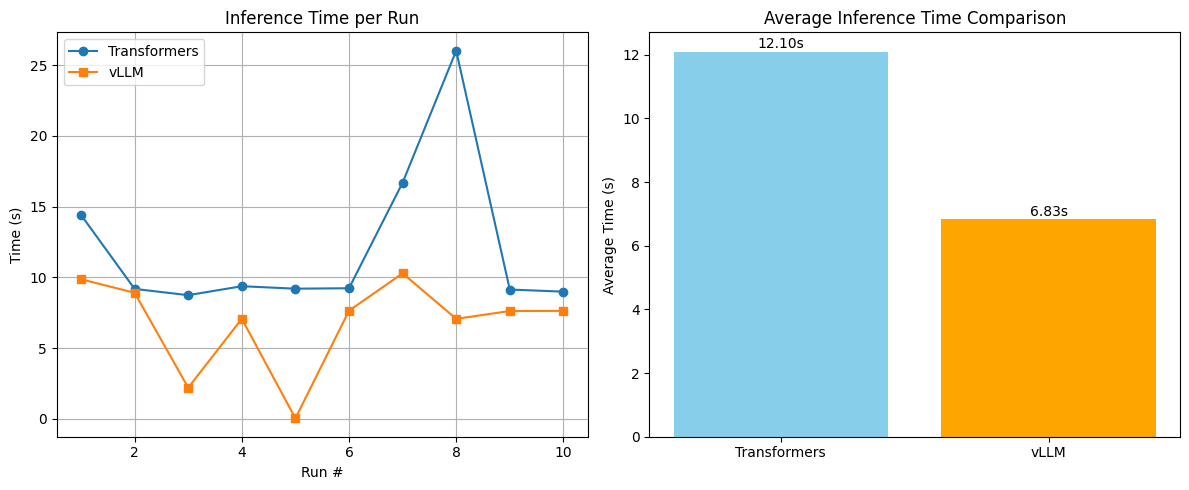

In [7]:
runs = range(1, 11)
avg_transformers = np.mean(transformers_times)
avg_vllm = np.mean(vllm_times)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---- Subplot 1: Line plot ----
axes[0].plot(runs, transformers_times, marker='o', label='Transformers')
axes[0].plot(runs, vllm_times, marker='s', label='vLLM')
axes[0].set_title("Inference Time per Run")
axes[0].set_xlabel("Run #")
axes[0].set_ylabel("Time (s)")
axes[0].legend()
axes[0].grid(True)

# ---- Subplot 2: Bar chart ----
axes[1].bar(['Transformers', 'vLLM'], [avg_transformers, avg_vllm], color=['skyblue', 'orange'])
axes[1].set_title("Average Inference Time Comparison")
axes[1].set_ylabel("Average Time (s)")

# Annotate bars with values
for i, val in enumerate([avg_transformers, avg_vllm]):
    axes[1].text(i, val + 0.1, f"{val:.2f}s", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


#### 🔍 Observations
1. **Consistency:**  
   vLLM shows much flatter timing across runs, while Transformers exhibits higher variance — including one significant spike (~26 s).  
   This indicates that vLLM provides **more stable and predictable latency**.

2. **Warm-up behavior:**  
   Both frameworks have slightly slower first runs due to CUDA initialization and caching. After that, vLLM stabilizes quickly, maintaining steady performance.

3. **Efficiency:**  
   vLLM’s optimized runtime reduces latency and improves utilization, even for single-prompt inference.


#### 🧠 Conclusion
vLLM achieves **nearly double the speed** of standard Transformers while maintaining **lower variance and smoother performance** across runs.  
These results highlight vLLM’s advantage for **production inference** and **high-throughput workloads** where both speed and consistency are crucial.

## 📦 Client-Side Caching: CacheSaver

To complement our server-side optimization, we’ll now explore a **client-side optimization** layer: **CacheSaver**.

### What is CacheSaver?
CacheSaver is a plug-and-play client framework that sits **outside the model internals** or server setup and adds intelligent caching to inference calls.  
It works with *any* model or API (open-source or closed-source) and introduces:
- Transparent reuse of past responses instead of new inference calls.  
- Namespace-aware caching to ensure **deterministic reproducibility** while preserving model randomness.  
- Low overhead: one line of code to integrate, no heavy dependencies.

Check out CacheSaver's GitHub: [https://github.com/au-clan/cachesaver/tree/main](https://github.com/au-clan/cachesaver/tree/main) 🚀

### Why use CacheSaver?
- 🧠 **Reduces inference cost & latency** by avoiding redundant calls when the same prompt appears again.  
- 🔁 **Improves reproducibility**: identical prompts yield identical cached responses (useful for benchmarking or reasoning chains).  
- 🔄 **Enables reuse in multi-step workflows** (e.g., agent reasoning, chains of prompts) by detecting overlapping sub-tasks and skipping repeated computation.

Let’s set it up and see the impact!  


In [15]:
prompt = "Suggest a startup idea and its one-sentence elevator pitch. Keep the textual style format of the following examples : 'EcoFleet: AI for optimizing delivery routes', 'LinguaLoop: Personalized language tutoring via voice AI', 'TaskHaven: Calm productivity app for remote workers'"

### 💡 Why Randomness Matters Before Caching

Before introducing CacheSaver, it’s worth seeing how *vanilla* OpenAI inference behaves when you call the same prompt multiple times.  

Even though the prompt and model are identical, each new request is treated as an independent sampling process, meaning the model will likely generate **different startup ideas** each time.  

In the example below, we:  
1. Ask for **3 startup ideas** first.  
2. Then immediately ask for **2 more startup ideas** using the same prompt.  

You’ll notice that the “follow-up” ideas don’t necessarily overlap with the first batch, each call is random and stateless.


In [ ]:
from openai import AsyncOpenAI

client = AsyncOpenAI()

time = time.time()
response = await client.chat.completions.create(
    model="gpt-4.1-nano",
    messages=[
        {"role": "user", "content": prompt}
    ],
    n=3
)
print(f"Initial ideas:\n\n", "\n".join(["\t -"+choice.message.content.strip() for choice in response.choices]))

response = await client.chat.completions.create(
    model="gpt-4.1-nano",
    messages=[
        {"role": "user", "content": prompt}
    ],
    n=2
)
print(f"Follow-up ideas:\n\n", "\n".join(["\t -"+choice.message.content.strip() for choice in response.choices]))
openai_time_first_run = time.time() - time

Initial ideas:

 	 -SkillSwap: Peer-to-peer platform for exchanging professional skills through time banking
	 -Farm2Table: Blockchain-based platform connecting local farmers directly with consumers
	 -GreenPlan: AI-powered platform for personalized urban sustainable living plans
Follow-up ideas:

 	 -FarmShare: Community-driven platform for local urban farms to sell fresh produce directly to consumers
	 -GreenVault: blockchain-based platform for tracking and trading carbon credits


### 🧠 When You Need to Regenerate Lost Ideas

Imagine you ran the earlier experiment, but forgot to save or record the ideas that were generated.  
Now you want to re-run the same prompt, this time asking for **five startup ideas** to make up for the ones you lost.

In a normal (non-cached) setup, this new call will **resample all five ideas from scratch**, producing an entirely new set of outputs.  
Even though it’s the same model and prompt, the randomness of sampling means you can’t easily recover or reproduce the original results.


**`TODO:`** Re-initialise the AyncOpenAI client and generate 5 more ideas in the same manner as before.

In [ ]:
client = AsyncOpenAI()

time = time.time()
response = await client.chat.completions.create(
    model="gpt-4.1-nano",
    messages=[
        {"role": "user", "content": prompt}
    ],
    n=5
)
print(f"Follow-up ideas:\n\n", "\n".join(["\t -"+choice.message.content.strip() for choice in response.choices]))
openai_time_second_run = time.time() - time

Follow-up ideas:

 	 -Farm2Fork: Transparent supply chain platform connecting farmers directly with consumers
	 -GreenNest: Smart modular indoor gardens for urban apartments
	 -FarmLink: Blockchain platform connecting local farmers directly with consumers
	 -GreenShelf: Smart inventory management for local sustainable stores
	 -SnapFarm: Urban vertical farming with automated harvest and delivery


### 💾 Imagine Running the Same Experiment with CacheSaver

Now, let’s see how this scenario changes when we introduce **CacheSaver**.  

CacheSaver acts as a reproducible “memory” for your LLM calls. It remembers what the model has already generated for a given prompt and namespace.  
So if you run the same experiment again (even in a new session or notebook cell), CacheSaver will:

1. **Reproduce** the exact same ideas you saw earlier — no more lost results.  
2. **Reuse** cached completions instead of re-sampling them from scratch.  
3. **Only generate missing completions** when you increase `n` (for example, going from 3 → 5 ideas).  

In [ ]:
from cachesaver.models.openai import AsyncOpenAI

client = AsyncOpenAI()

time = time.time()
response = await client.chat.completions.create(
    model="gpt-4.1-nano",
    messages=[
        {"role": "user", "content": prompt}
    ],
    n=3
)
print(f"Initial ideas:\n\n", "\n".join(["\t -"+choice.message.content.strip() for choice in response.choices]))

response = await client.chat.completions.create(
    model="gpt-4.1-nano",
    messages=[
        {"role": "user", "content": prompt}
    ],
    n=2
)
print(f"Follow-up ideas:\n\n", "\n".join(["\t -"+choice.message.content.strip() for choice in response.choices]))
cachesaver_time_first_run = time.time() - time

Initial ideas:

 	 -GreenNest: Smart modular homes for sustainable living
	 -GreenSnap: Urban farming platform transforming small spaces into sustainable food sources
	 -GreenSnap: AI-powered platform for sustainable urban gardening guidance
Follow-up ideas:

 	 -SkillSwap: Platform connecting professionals for peer-to-peer skill exchange
	 -FarmMesh: Smart digital marketplace connecting local organic growers directly with consumers


### ⚡ Regenerating with CacheSaver — Consistency and Reuse in Action

Now, let’s re-run the same request, this time with **CacheSaver** enabled.  

Because CacheSaver tracks results within a deterministic namespace, it recognizes that we’ve already generated some ideas for this exact prompt.  
When we now ask for **five startup ideas**, it will:

- Instantly **reuse** the cached ideas from earlier runs.   
- Return a **stable, reproducible list** that remains the same across sessions and environments.  

This is where CacheSaver’s real value becomes obvious: instead of unpredictable, random generations, you get consistent, memory-backed outputs.

In [ ]:
client = AsyncOpenAI()

time = time.time()
response = await client.chat.completions.create(
    model="gpt-4.1-nano",
    messages=[
        {"role": "user", "content": prompt}
    ],
    n=5
)
print(f"Follow-up ideas:\n\n", "\n".join(["\t -"+choice.message.content.strip() for choice in response.choices]))
cachesaver_second_run = time.time() - time

Follow-up ideas:

 	 -GreenNest: Smart modular homes for sustainable living
	 -GreenSnap: Urban farming platform transforming small spaces into sustainable food sources
	 -GreenSnap: AI-powered platform for sustainable urban gardening guidance
	 -SkillSwap: Platform connecting professionals for peer-to-peer skill exchange
	 -FarmMesh: Smart digital marketplace connecting local organic growers directly with consumers


**`Discussion:`**  You’ve now measured the inference times for both runs, with and without CacheSaver. What do you notice about the difference between the first and second execution? Why does CacheSaver behave this way, and how might this affect real-world workloads?

### ⏱️ What We Should Observe

- **First run (Initial Generation):**  CacheSaver has no stored completions yet, so it performs full inference for all requested outputs.  
  Latency is normal, similar to standard OpenAI calls.

- **Experiment 2 (Cached Reuse):** CacheSaver recognizes previously seen prompts and reuses stored completions
  **Instant response**, results are loaded directly from the cache with virtually no model inference.

In short: the first run fills the cache, the second run benefits from it — making inference both **faster** and **deterministic**.
